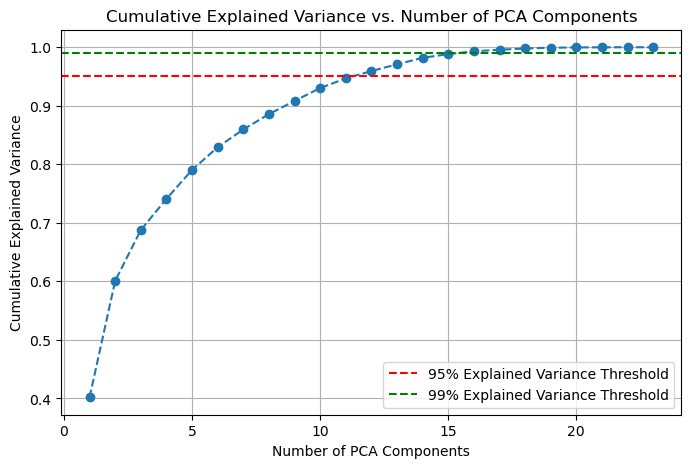

Performing 5-Fold Cross-Validation:

Evaluating Naive Bayes with cross-validation...
Naive Bayes - Mean Test Accuracy: 0.720, Mean Test AUC: 0.671
Mean Train Accuracy: 0.942, Mean Train AUC: 0.955


Evaluating SVM with cross-validation...
SVM - Mean Test Accuracy: 0.775, Mean Test AUC: 0.871
Mean Train Accuracy: 0.930, Mean Train AUC: 0.986


Evaluating Random Forest with cross-validation...
Random Forest - Mean Test Accuracy: 0.798, Mean Test AUC: 0.868
Mean Train Accuracy: 1.000, Mean Train AUC: 1.000

Random forest model hyperparameter tuning: best parameters found:  {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 40}


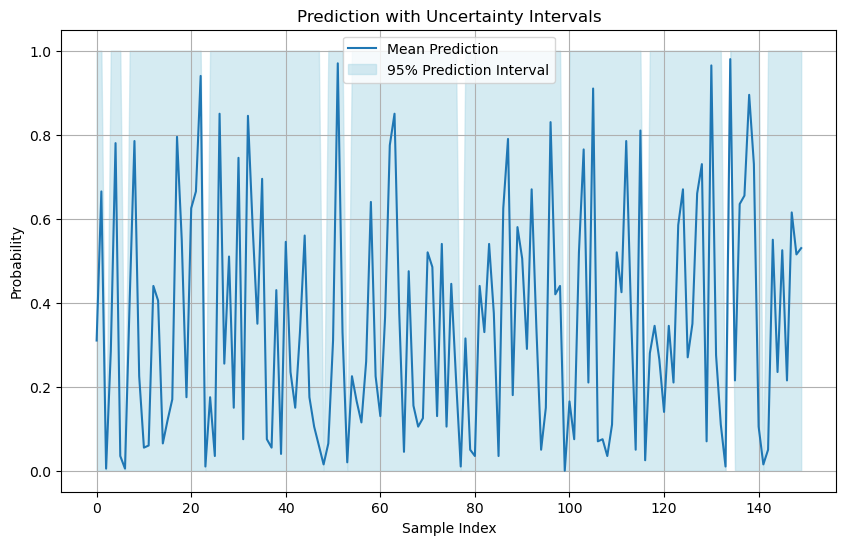

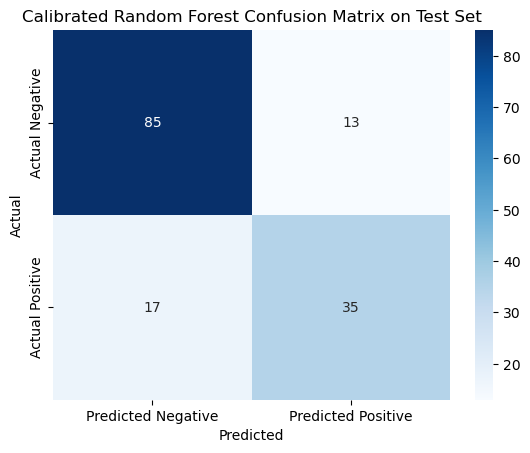

Calibrated Random Forest Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85        98
           1       0.73      0.67      0.70        52

    accuracy                           0.80       150
   macro avg       0.78      0.77      0.77       150
weighted avg       0.80      0.80      0.80       150

Calibrated Random Forest Test Set AUC: 0.88
Calibrated Random Forest Test Set Log Loss: 0.42


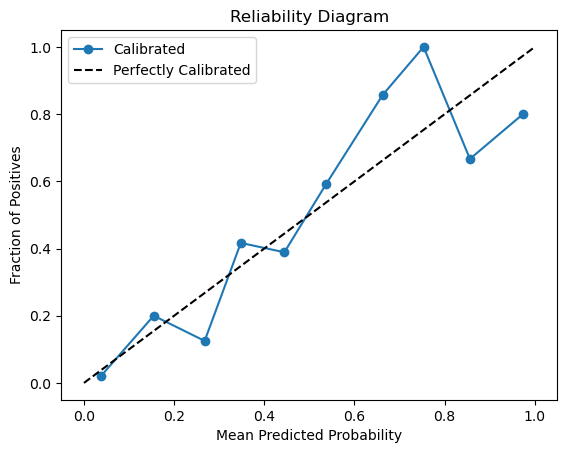

Out-of-domain instances: 3 out of 150
In-domain Classification Report (Calibrated):
              precision    recall  f1-score   support

           0       0.83      0.86      0.85        96
           1       0.72      0.67      0.69        51

    accuracy                           0.80       147
   macro avg       0.78      0.77      0.77       147
weighted avg       0.79      0.80      0.79       147

Out-of-domain Classification Report (Calibrated):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



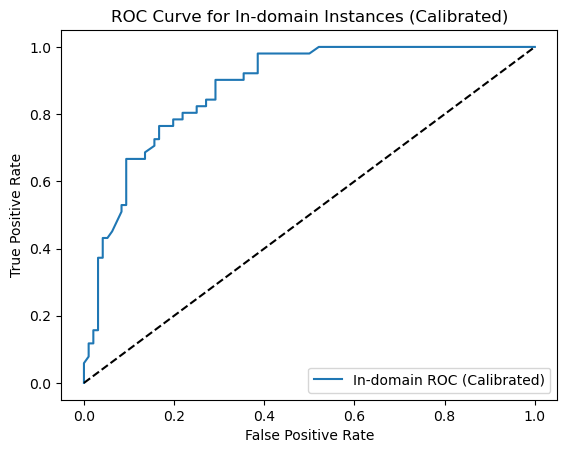

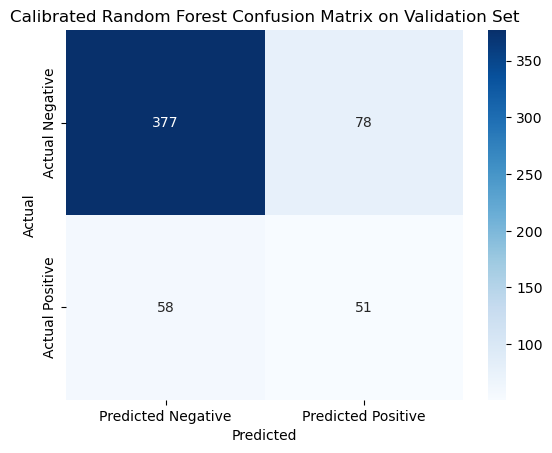

Calibrated Random Forest Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       455
           1       0.40      0.47      0.43       109

    accuracy                           0.76       564
   macro avg       0.63      0.65      0.64       564
weighted avg       0.78      0.76      0.77       564

Calibrated Random Forest Validation Set AUC: 0.76
Calibrated Random Forest Validation Set Log Loss: 0.52


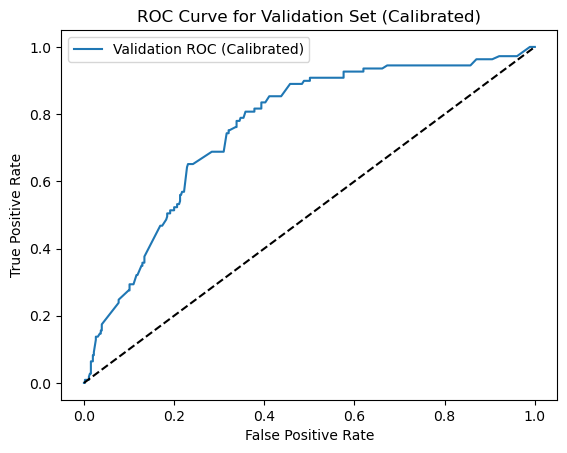

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, PandasTools, AllChem, DataStructs, rdFingerprintGenerator
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, log_loss, roc_curve
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV


# Load SDF file and convert to DataFrame using a raw string for the path
sdf_file = "Structures_759_training.sdf"  
sdf_supplier = Chem.SDMolSupplier(sdf_file)
df = PandasTools.LoadSDF(sdf_file, smilesName='SMILES', molColName='Molecule', includeFingerprints=False)

# List of selected descriptors
selected_columns = [
    'r_qp_mol_MW', 'r_qp_volume', 'r_qp_SASA', 'r_qp_PSA',
    'r_qp_QPlogS', 'r_qp_CIQPlogS', 'r_qp_QPlogPoct', 'r_qp_QPlogPo/w',
    'r_qp_dipole', 'r_qp_donorHB', 'r_qp_accptHB',
    'r_qp_QPPCaco', 'r_qp_QPlogBB', 'i_qp_HumanOralAbsorption',
    'r_qp_PercentHumanOralAbsorption', 'r_qp_QPlogHERG',
    'r_qp_IP(eV)', 'r_qp_EA(eV)',
    'i_qp_#stars', 'i_qp_#rotor', 'i_qp_RuleOfFive', 'i_qp_RuleOfThree', 'i_qp_#NandO'
]

# Calculate the molecular fingerprint fcfp_6 and expand it into multiple columns
morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=2048)  
def calculate_fcfp6(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fcfp6 = morgan_gen.GetFingerprint(mol)
    array = np.zeros((2048,), dtype=int)
    DataStructs.ConvertToNumpyArray(fcfp6, array)
    return array

# Generate Morgan fingerprints and convert to DataFrame
fcfp6_data = df['SMILES'].apply(calculate_fcfp6)
fcfp6_df = pd.DataFrame(fcfp6_data.tolist(), index=df.index)

# Concatenate original features with Morgan fingerprints
features = df[selected_columns].join(fcfp6_df).dropna()

# Convert Descriptor Columns to Floats
for column in selected_columns:
    features[column] = pd.to_numeric(features[column], errors='coerce')

# Handle any NaN values after conversion (e.g., by dropping or imputing)
features.dropna(subset=selected_columns, inplace=True)

# Extract the target variable 'Stable'
target_column = 'Stable'
labels = df[target_column].loc[features.index]
labels = labels.astype(int)  # Ensure labels are integers

# Standardizing the descriptor features
scaler = StandardScaler()
scaled_descriptors = scaler.fit_transform(features[selected_columns])

# Apply PCA to scaled descriptor features
pca = PCA(n_components=9)  # Adjust the number of components if needed
principal_components = pca.fit_transform(scaled_descriptors)

# Compute cumulative explained variance for all components
pca_full = PCA().fit(scaled_descriptors)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(selected_columns) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of PCA Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance Threshold')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% Explained Variance Threshold')
plt.legend()
plt.grid()
plt.show()

# Combine PCA transformed descriptors with original Morgan fingerprints
combined_features = np.hstack((principal_components, fcfp6_df.loc[features.index].values))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, labels, test_size=0.2, random_state=42
)
# Ensure train/test labels are integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Cross-validation setup to determine which model is the best for further optimization: Naive Bayesian, SVM, Random Forest
models = {
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
}
cv_results = {}
print("Performing 5-Fold Cross-Validation:")
for model_name, model in models.items():
    print(f"\nEvaluating {model_name} with cross-validation...")
    scores = cross_validate(model, X_train, y_train, cv=5, scoring=['accuracy', 'roc_auc'], return_train_score=True)
    cv_results[model_name] = scores
    print(f"{model_name} - Mean Test Accuracy: {scores['test_accuracy'].mean():.3f}, Mean Test AUC: {scores['test_roc_auc'].mean():.3f}")
    print(f"Mean Train Accuracy: {scores['train_accuracy'].mean():.3f}, Mean Train AUC: {scores['train_roc_auc'].mean():.3f}\n")

# 3. Random Forest Model with Hyperparameter Optimization (Tuning)
param_dist = {
    'n_estimators': np.arange(50, 300, 50),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=100,  
cv=5, scoring='accuracy', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
print("Random forest model hyperparameter tuning: best parameters found: ", random_search.best_params_)

best_rf_model = random_search.best_estimator_
calibrated_rf_model = CalibratedClassifierCV(best_rf_model, method='isotonic', cv=5)
calibrated_rf_model.fit(X_train, y_train)

# Function to calculate uncertainty intervals
def predict_with_uncertainty(model, X, percentile=95):
    predictions = np.array([tree.predict_proba(X)[:, 1] for tree in model.estimators_])
    mean_prediction = np.mean(predictions, axis=0)
    lower_bound = np.percentile(predictions, (100 - percentile) / 2.0, axis=0)
    upper_bound = np.percentile(predictions, 100 - ((100 - percentile) / 2.0), axis=0)
    return mean_prediction, lower_bound, upper_bound

# Predict with the Calibrated Model and calculate uncertainty
y_prob_calibrated = calibrated_rf_model.predict_proba(X_test)[:, 1]
y_pred_calibrated = calibrated_rf_model.predict(X_test).astype(int)  # Convert predictions to integers

# Calculate uncertainty
mean_pred, lower, upper = predict_with_uncertainty(best_rf_model, X_test)

# Plotting uncertainty intervals
plt.figure(figsize=(10, 6))
plt.plot(mean_pred, label='Mean Prediction')
plt.fill_between(range(len(mean_pred)), lower, upper, color='lightblue', alpha=0.5, label='95% Prediction Interval')
plt.title('Prediction with Uncertainty Intervals')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix and Classification Report
cm_calibrated = confusion_matrix(y_test, y_pred_calibrated)
sns.heatmap(cm_calibrated, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Calibrated Random Forest Confusion Matrix on Test Set')
plt.show()

print("Calibrated Random Forest Classification Report on Test Set:")
print(classification_report(y_test, y_pred_calibrated))
auc_score_calibrated = roc_auc_score(y_test, y_prob_calibrated)
print(f"Calibrated Random Forest Test Set AUC: {auc_score_calibrated:.2f}")
logloss_calibrated = log_loss(y_test, y_prob_calibrated)
print(f"Calibrated Random Forest Test Set Log Loss: {logloss_calibrated:.2f}")

# Reliability Diagram
prob_true, prob_pred = calibration_curve(y_test, y_prob_calibrated, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram')
plt.legend()
plt.show()

# Applicability Domain using Nearest Neighbors
knn = NearestNeighbors(n_neighbors=5).fit(X_train)
distances, _ = knn.kneighbors(X_test)
threshold = np.percentile(distances, 95)
out_of_domain = distances.mean(axis=1) > threshold

print(f"Out-of-domain instances: {np.sum(out_of_domain)} out of {len(y_test)}")

# Separate Analysis for In-Domain and Out-Of-Domain Predictions
in_domain_idx = ~out_of_domain
out_domain_idx = out_of_domain

# In-Domain Evaluations
print("In-domain Classification Report (Calibrated):")
print(classification_report(y_test[in_domain_idx], y_pred_calibrated[in_domain_idx]))

# Out-of-Domain Evaluations
print("Out-of-domain Classification Report (Calibrated):")
if np.any(out_domain_idx):
    print(classification_report(y_test[out_domain_idx], y_pred_calibrated[out_domain_idx]))
else:
    print("No out-of-domain instances.")

# ROC Curve for In-Domain Predictions using Calibrated Probabilities
fpr_in, tpr_in, _ = roc_curve(y_test[in_domain_idx], y_prob_calibrated[in_domain_idx])
plt.plot(fpr_in, tpr_in, label='In-domain ROC (Calibrated)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for In-domain Instances (Calibrated)')
plt.legend()
plt.show()

sdf_file_unseen = "Structures_test_571.sdf" 
df_validation = PandasTools.LoadSDF(sdf_file_unseen, smilesName='SMILES', molColName='Molecule', includeFingerprints=False)

# Prepare features for the validation set using common columns
features_validation = df_validation[selected_columns].dropna()
labels_validation = df_validation[target_column].loc[features_validation.index].astype(int)  # Ensure labels are integers

# Calculate the molecular fingerprint fcfp_6 for validation set
fcfp6_validation_data = df_validation['SMILES'].apply(calculate_fcfp6)
fcfp6_validation_df = pd.DataFrame(fcfp6_validation_data.tolist(), index=df_validation.index)

# Standardize Validation Descriptor Features
scaled_features_validation = scaler.transform(features_validation)

# Apply PCA Transformation to the Validation Set
principal_components_validation = pca.transform(scaled_features_validation)

# Combine PCA-transformed descriptors with Morgan fingerprints for validation set
combined_features_validation = np.hstack((principal_components_validation, fcfp6_validation_df.loc[features_validation.index].values))

# Evaluate the Random Forest Model on the Validation Set
y_pred_validation = calibrated_rf_model.predict(combined_features_validation).astype(int)  # Convert predictions to integers
y_prob_validation = calibrated_rf_model.predict_proba(combined_features_validation)[:, 1]

# Confusion Matrix for validation predictions
cm_validation = confusion_matrix(labels_validation, y_pred_validation)
sns.heatmap(cm_validation, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Calibrated Random Forest Confusion Matrix on Validation Set')
plt.show()

# Classification Report for the validation set
print("Calibrated Random Forest Classification Report on Validation Set:")
print(classification_report(labels_validation, y_pred_validation))

# AUC and Log Loss for the Validation Set
auc_score_validation = roc_auc_score(labels_validation, y_prob_validation)
print(f"Calibrated Random Forest Validation Set AUC: {auc_score_validation:.2f}")
logloss_validation = log_loss(labels_validation, y_prob_validation)
print(f"Calibrated Random Forest Validation Set Log Loss: {logloss_validation:.2f}")

# ROC Curve for Validation Predictions Using Calibrated Probabilities
fpr_val, tpr_val, _ = roc_curve(labels_validation, y_prob_validation)
plt.plot(fpr_val, tpr_val, label=f'Validation ROC (Calibrated)')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Set (Calibrated)')
plt.legend()
plt.show()
